### Use the instructor's notebook [here](https://github.com/nipunbatra/ml-teaching/blob/master/notebooks/movie-recommendation-knn-mf.ipynb) on matrix factorization, and solve the following questions. Use the above image from Q4 and complete the rectangular missing patch for three cases, i.e. a rectangular block of 30X30 is assumed missing from the image. Choose rank r yourself. Vary the patch location as follows.


1. an area with mainly a single color.

In [344]:
import os
import torch

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision
import matplotlib.pyplot as plt
from einops import rearrange
import matplotlib.gridspec as gridspec


In [345]:
if os.path.exists("dog.jpg"):
    print('dog.jpg exists')
else:    
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg
    


dog.jpg exists


In [346]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)
# print(img)


torch.Size([3, 1365, 2048])


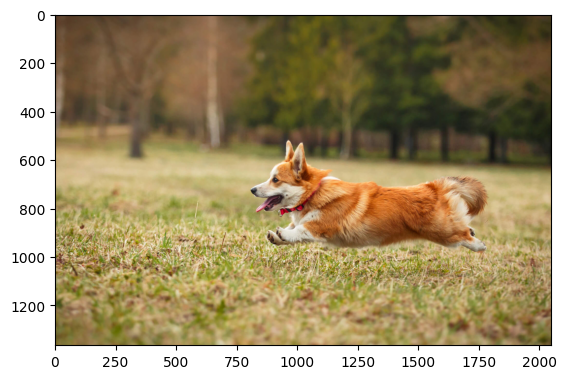

In [347]:
plt.imshow(rearrange(img,'c h w -> h w c'))

In [348]:
from sklearn import preprocessing
scaler_img=preprocessing.MinMaxScaler().fit(img.reshape(-1,1))
scaler_img

MinMaxScaler()

In [349]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape
# print(img_scaled)
img_scaled=torch.tensor(img_scaled)
img_scaled=img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [350]:
crop=torchvision.transforms.functional.crop(img_scaled.cpu(),600,800,300,300)
crop.shape

torch.Size([3, 300, 300])

torch.Size([3, 300, 300])


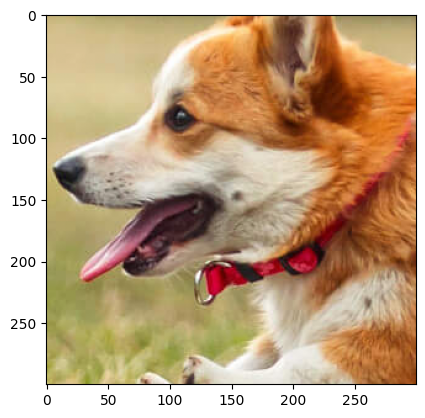

In [351]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
print(crop.shape)


In [352]:
def get_patch(image,patch_size,x_min,y_min):
    return image[:,y_min:y_min+patch_size,x_min:x_min+patch_size]

In [353]:
# Check if the standard deviation across channels is small, indicating a single color
def is_mostly_single_color(patch):
    return torch.std(patch) < 0.1


def has_multiple_channels(patch,threshold=0.1,min_channel=2):
    std_devs_per_channel=torch.std(patch,dim=(1,2))
    return (std_devs_per_channel > threshold).sum()>=min_channel

def has_at_least_n_colors(patch, min_colors=5):
    unique_colors_per_channel = [torch.unique(patch[channel, :, :]).shape[0] for channel in range(patch.shape[0])]
    # print(unique_colors_per_channel)
    # print(unique_colors_per_channel)
    return all(count >= min_colors for count in unique_colors_per_channel)

In [354]:
image=crop
image.shape

torch.Size([3, 300, 300])

In [355]:
image_shape = (3, 300, 300)
image = image
patch_size = 30
min_x = 0
max_x = image.shape[2] - patch_size
min_y = image.shape[1] - patch_size
max_y = 0
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


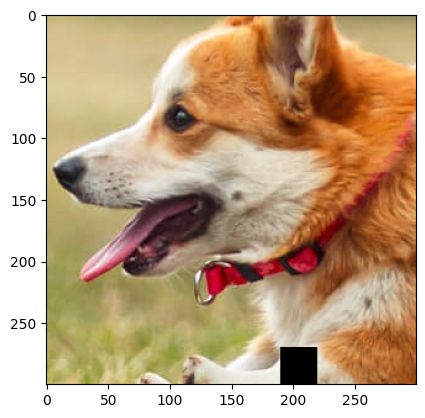

In [356]:
def get_patch(image,patch_size,x_min,y_min):
    return image[:,y_min:y_min+patch_size,x_min:x_min+patch_size]

def create_masked_matrix(original_matrix, block_size=30):
    masked_matrix = original_matrix.clone()
    min_x = 0
    max_x = image.shape[2] - patch_size
    min_y = image.shape[1] - patch_size
    max_y = 0
    # Choose the location based on color characteristics
    selected_region = None
    for y in range(original_matrix.shape[1] - block_size, 0, -10):
        for x in range(0,original_matrix.shape[2] - block_size, 10):
            # Fetch the patch
            patch = get_patch(original_matrix, block_size, x, y)

            # Check if the patch meets the condition 
            if is_mostly_single_color(patch):
                selected_region = (y, x)
                break

        if selected_region is not None:
            break

    # Update the masked matrix
    masked_matrix[:, 
                  selected_region[0]:selected_region[0]+block_size, 
                  selected_region[1]:selected_region[1]+block_size] = 0

    return masked_matrix
masked_image = create_masked_matrix(crop)
plt.imshow(rearrange(masked_image, 'c h w -> h w c').cpu().numpy())


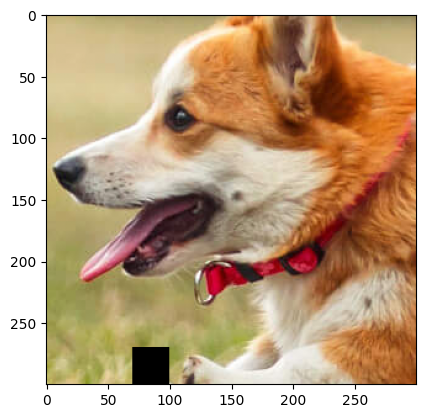

In [357]:
def create_masked_matrix(original_matrix, block_size=30):
    masked_matrix = original_matrix.clone()
    min_x = 0
    max_x = image.shape[2] - patch_size
    min_y = image.shape[1] - patch_size
    max_y = 0
    # Choose the location based on color characteristics
    selected_region = None
    for y in range(original_matrix.shape[1] - block_size, 0, -10):
        for x in range(0,original_matrix.shape[2] - block_size, 10):
            # Fetch the patch
            patch = get_patch(original_matrix, block_size, x, y)

            # Check if the patch meets the condition 
            if has_multiple_channels(patch):
                selected_region = (y, x)
                break

        if selected_region is not None:
            break

    # Update the masked matrix
    masked_matrix[:, 
                  selected_region[0]:selected_region[0]+block_size, 
                  selected_region[1]:selected_region[1]+block_size] = 0

    return masked_matrix
masked_image_two_channel = create_masked_matrix(crop)
plt.imshow(rearrange(masked_image_two_channel, 'c h w -> h w c').cpu().numpy())


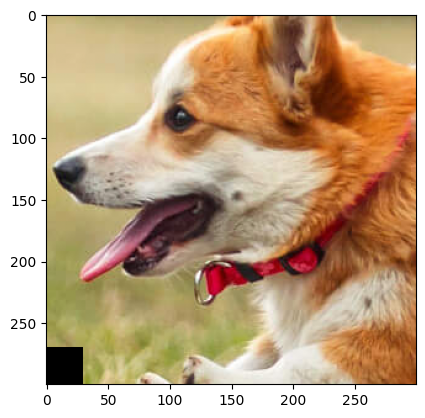

In [358]:
def get_patch(image,patch_size,x_min,y_min):
    return image[:,y_min:y_min+patch_size,x_min:x_min+patch_size]

def create_masked_matrix(original_matrix, block_size=30):
    masked_matrix = original_matrix.clone()
    min_x = 0
    max_x = image.shape[2] - patch_size
    min_y = image.shape[1] - patch_size
    max_y = 0
    # Choose the location based on color characteristics
    selected_region = None
    for y in range(original_matrix.shape[1] - block_size, 0, -10):
        for x in range(0,original_matrix.shape[2] - block_size, 10):
            # Fetch the patch
            patch = get_patch(original_matrix, block_size, x, y)

            # Check if the patch meets the condition 
            if has_at_least_n_colors(patch):
                selected_region = (y, x)
                break

        if selected_region is not None:
            break

    # Update the masked matrix
    masked_matrix[:, 
                  selected_region[0]:selected_region[0]+block_size, 
                  selected_region[1]:selected_region[1]+block_size] = 0

    return masked_matrix
masked_image_five_channel = create_masked_matrix(crop)
plt.imshow(rearrange(masked_image_five_channel, 'c h w -> h w c').cpu().numpy())


In [359]:
r = 20
W = torch.randn(crop.shape[1], r, requires_grad=True, device=device)
H = torch.randn(r, crop.shape[2], requires_grad=True, device=device)
print(W.shape, H.shape)


torch.Size([300, 20]) torch.Size([20, 300])


In [360]:
crop=crop.to(device)
masked_image=masked_image.to(device)
masked_image_five_channel=masked_image_five_channel.to(device)
masked_image_two_channel=masked_image_two_channel.to(device)
with torch.no_grad():
    loss=torch.norm(torch.mm(W, H)-masked_image)
    print(loss)

with torch.no_grad():
    loss_two=torch.norm(torch.mm(W, H)-masked_image_two_channel)
    print(loss_two)    

with torch.no_grad():
    loss_five=torch.norm(torch.mm(W, H)-masked_image_five_channel)
    print(loss_five)    

tensor(2320.0541, device='cuda:0', dtype=torch.float64)
tensor(2320.2395, device='cuda:0', dtype=torch.float64)
tensor(2320.0607, device='cuda:0', dtype=torch.float64)


In [361]:
def plot_original_masked_reconstructed_images(original, masked_image, reconstructed, title1="Original", title2="Masked Image", title3="Reconstructed"):
    """
    Plots the original, masked, and reconstructed images side-by-side.

    Args:
        original: The original image tensor with shape (channels, height, width).
        masked_image: The masked image tensor with shape (channels, height, width).
        reconstructed: The reconstructed image tensor with shape (channels, height, width).
        title1, title2, title3: Titles for the subplots (optional).
    """

    num_channels, height, width = original.shape
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    # Plot original image
    axs[0].imshow(rearrange(original, 'c h w -> h w c').cpu().numpy())
    axs[0].set_title(title1)

    # Plot masked image
    axs[1].imshow(rearrange(masked_image, 'c h w -> h w c').cpu().numpy())
    axs[1].set_title(title2)

    # Plot reconstructed image (assuming 3 channels)
    axs[2].imshow(reconstructed.cpu().detach().numpy())
    axs[2].set_title(title3)

    plt.tight_layout()  # Adjust spacing between subplots automatically
    plt.show()

Iteration 0, Loss: 4104.095919689426


Iteration 1000, Loss: 57.932161981098474
Iteration 2000, Loss: 44.36760721317539
Iteration 3000, Loss: 40.38215436959308
Iteration 4000, Loss: 38.139254995473486
Iteration 5000, Loss: 37.01950221988126
Iteration 6000, Loss: 36.37264291533184
Iteration 7000, Loss: 36.143185292173634
Iteration 8000, Loss: 35.963993898929374
Iteration 9000, Loss: 35.904600804013356


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


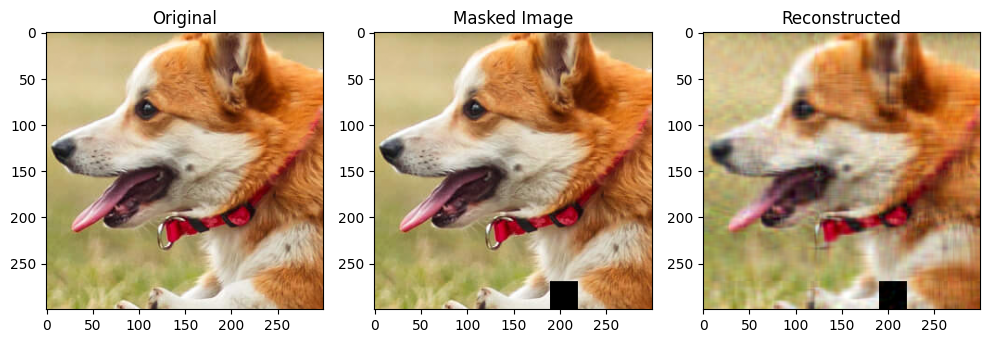

In [362]:
r = 20  # Rank for each channel
num_iterations = 10000
learning_rate = 0.01
# Initialize W and H matrices separately for each channel
Ws = []
Hs = []
for channel in range(masked_image.shape[0]):
    W = torch.randn(masked_image.shape[1], r, requires_grad=True, device=device)
    H = torch.randn(r, masked_image.shape[2], requires_grad=True, device=device)
    Ws.append(W)
    Hs.append(H)

# ... (optimizer and training loop remain the same)
optimizer = torch.optim.Adam(Ws + Hs, lr=learning_rate)
for i in range(num_iterations):
    losses = []
    for channel in range(masked_image.shape[0]):
        loss = torch.norm(torch.mm(Ws[channel], Hs[channel]) - masked_image[channel])
        losses.append(loss)
    loss = sum(losses)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

# Reconstruct the image with 3 channels
reconstructed_channels = []
for channel in range(masked_image.shape[0]):
    reconstructed_channel = torch.mm(Ws[channel], Hs[channel])
    reconstructed_channels.append(reconstructed_channel)
reconstructed_single = torch.stack(reconstructed_channels, dim=0)  # Combine channels
reconstructed_single=rearrange(reconstructed_single,'c h w -> h w c')
# Plot the original and reconstructed images
plot_original_masked_reconstructed_images(crop, masked_image,reconstructed_single, title1="Original", title2="Masked Image", title3="Reconstructed")

torch.Size([300, 20]) torch.Size([20, 300])
Iteration 0, Loss: 4070.8947554659026


Iteration 1000, Loss: 56.0870820546599
Iteration 2000, Loss: 43.88968343762663
Iteration 3000, Loss: 39.38062485021224
Iteration 4000, Loss: 37.198532817645464
Iteration 5000, Loss: 36.080564886905144
Iteration 6000, Loss: 35.62944997864082
Iteration 7000, Loss: 35.442169270919436
Iteration 8000, Loss: 35.36818768696396
Iteration 9000, Loss: 35.28448067599457


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


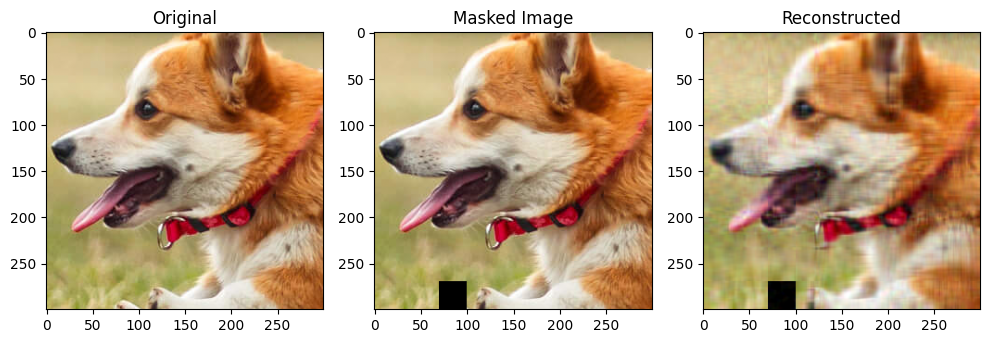

In [363]:
r = 20
W = torch.randn(crop.shape[1], r, requires_grad=True, device=device)
H = torch.randn(r, crop.shape[2], requires_grad=True, device=device)
print(W.shape, H.shape)
r = 20  # Rank for each channel

# Initialize W and H matrices separately for each channel
Ws = []
Hs = []
for channel in range(masked_image_two_channel.shape[0]):
    W = torch.randn(masked_image_two_channel.shape[1], r, requires_grad=True, device=device)
    H = torch.randn(r, masked_image_two_channel.shape[2], requires_grad=True, device=device)
    Ws.append(W)
    Hs.append(H)

# ... (optimizer and training loop remain the same)
optimizer = torch.optim.Adam(Ws + Hs, lr=learning_rate)
for i in range(num_iterations):
    losses = []
    for channel in range(masked_image_two_channel.shape[0]):
        loss = torch.norm(torch.mm(Ws[channel], Hs[channel]) - masked_image_two_channel[channel])
        losses.append(loss)
    loss = sum(losses)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

# Reconstruct the image with 3 channels
reconstructed_channels = []
for channel in range(masked_image_two_channel.shape[0]):
    reconstructed_channel = torch.mm(Ws[channel], Hs[channel])
    reconstructed_channels.append(reconstructed_channel)
reconstructed_two = torch.stack(reconstructed_channels, dim=0)  # Combine channels
reconstructed_two=rearrange(reconstructed_two,'c h w -> h w c')
# Plot the original and reconstructed images
plot_original_masked_reconstructed_images(crop, masked_image_two_channel,reconstructed_two, title1="Original", title2="Masked Image", title3="Reconstructed")

torch.Size([300, 20]) torch.Size([20, 300])
Iteration 0, Loss: 4055.215986514139


Iteration 1000, Loss: 56.41904151908636
Iteration 2000, Loss: 44.61179882968615
Iteration 3000, Loss: 40.173002473439496
Iteration 4000, Loss: 37.97240197619021
Iteration 5000, Loss: 36.784908700463944
Iteration 6000, Loss: 36.217347798385916
Iteration 7000, Loss: 35.96514430819352
Iteration 8000, Loss: 35.8290761250508
Iteration 9000, Loss: 35.740997097204094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


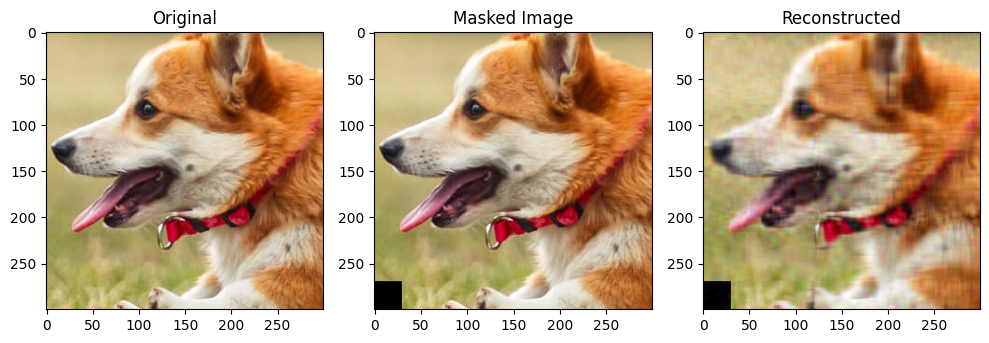

In [364]:
r = 20
W = torch.randn(crop.shape[1], r, requires_grad=True, device=device)
H = torch.randn(r, crop.shape[2], requires_grad=True, device=device)
print(W.shape, H.shape)
r = 20  # Rank for each channel

# Initialize W and H matrices separately for each channel
Ws = []
Hs = []
for channel in range(masked_image_five_channel.shape[0]):
    W = torch.randn(masked_image_five_channel.shape[1], r, requires_grad=True, device=device)
    H = torch.randn(r, masked_image_five_channel.shape[2], requires_grad=True, device=device)
    Ws.append(W)
    Hs.append(H)

# ... (optimizer and training loop remain the same)
optimizer = torch.optim.Adam(Ws + Hs, lr=learning_rate)
for i in range(num_iterations):
    losses = []
    for channel in range(masked_image_five_channel.shape[0]):
        loss = torch.norm(torch.mm(Ws[channel], Hs[channel]) - masked_image_five_channel[channel])
        losses.append(loss)
    loss = sum(losses)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

# Reconstruct the image with 3 channels
reconstructed_channels = []
for channel in range(masked_image_five_channel.shape[0]):
    reconstructed_channel = torch.mm(Ws[channel], Hs[channel])
    reconstructed_channels.append(reconstructed_channel)
reconstructed_five = torch.stack(reconstructed_channels, dim=0)  # Combine channels
reconstructed_five=rearrange(reconstructed_five,'c h w -> h w c')
# Plot the original and reconstructed images
plot_original_masked_reconstructed_images(crop, masked_image_five_channel,reconstructed_five, title1="Original", title2="Masked Image", title3="Reconstructed")

In [365]:
#Compute the following metrics: RMSE on predicted v/s ground truth high resolution image

ground_truth = crop
predicted = rearrange(reconstructed_single, 'h w c -> c h w')
rmse_single = torch.sqrt(torch.mean((ground_truth - predicted) ** 2))
print(f"RMSE: {rmse_single.item()}")
predicted_two = rearrange(reconstructed_two, 'h w c -> c h w')
rmse_two = torch.sqrt(torch.mean((ground_truth - predicted_two) ** 2))
print(f"RMSE: {rmse_two.item()}")
predicted_five = rearrange(reconstructed_five, 'h w c -> c h w')
rmse_five = torch.sqrt(torch.mean((ground_truth - predicted_five) ** 2))
print(f"RMSE: {rmse_five.item()}")


RMSE: 0.0951702739996172
RMSE: 0.07616955434714771
RMSE: 0.07388337671959253


In [366]:
import torch

def psnr(img1, img2):
    """
    Calculates the Peak Signal-to-Noise Ratio (PSNR) between two images.

    Args:
        img1: The first image tensor (ground truth).
        img2: The second image tensor (predicted).

    Returns:
        The PSNR value as a scalar in decibels ().
    """

    mse = torch.mean((img1 - img2) ** 2)  # Mean squared error
    max_pixel_value = 1.0  # Assuming 8-bit images (adjust if necessary)
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr

# Calculate PSNR values
psnr_single = psnr(ground_truth, predicted)
print(f"PSNR (Single): {psnr_single.item()} ")

psnr_two = psnr(ground_truth, predicted_two)
print(f"PSNR (Two): {psnr_two.item()} ")

psnr_five = psnr(ground_truth, predicted_five)
print(f"PSNR (Five): {psnr_five.item()} ")


PSNR (Single): 20.42997360665713 
PSNR (Two): 22.364371707389438 
PSNR (Five): 22.629065281102175 


In [367]:
from sklearn.linear_model import LinearRegression

# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


In [368]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [369]:
dog_X, dog_Y = create_coordinate_map(masked_image)

dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [370]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [371]:
import torch.nn as nn
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [372]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [373]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [374]:
train(net, 0.01, dog_X_scaled, dog_Y, 1000)


Epoch 0 loss: 0.820094
Epoch 100 loss: 0.116114
Epoch 200 loss: 0.041702
Epoch 300 loss: 0.038206
Epoch 400 loss: 0.038160
Epoch 500 loss: 0.038160
Epoch 600 loss: 0.038160
Epoch 700 loss: 0.038160
Epoch 800 loss: 0.038160
Epoch 900 loss: 0.038160


0.038160163909196854

In [375]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [376]:
X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)


In [377]:
X_rff.shape


torch.Size([90000, 37500])

In [378]:

net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.364687
Epoch 100 loss: 0.043123
Epoch 200 loss: 0.009495
Epoch 300 loss: 0.004598
Epoch 400 loss: 0.002562
Epoch 500 loss: 0.001500
Epoch 600 loss: 0.000933
Epoch 700 loss: 0.000629
Epoch 800 loss: 0.000468
Epoch 900 loss: 0.000385
Epoch 1000 loss: 0.000344
Epoch 1100 loss: 0.000324
Epoch 1200 loss: 0.000314
Epoch 1300 loss: 0.000309
Epoch 1400 loss: 0.000307
Epoch 1500 loss: 0.000305
Epoch 1600 loss: 0.000303
Epoch 1700 loss: 0.000302
Epoch 1800 loss: 0.000302
Epoch 1900 loss: 0.000301
Epoch 2000 loss: 0.000300
Epoch 2100 loss: 0.000300
Epoch 2200 loss: 0.000299
Epoch 2300 loss: 0.000299
Epoch 2400 loss: 0.000298


0.0002978252887260169

In [379]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


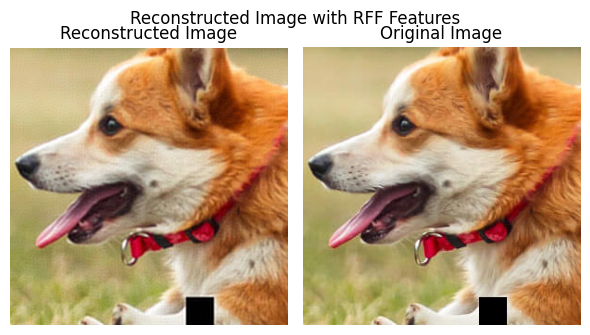

In [380]:
plot_reconstructed_and_original_image(masked_image, net, X_rff, title="Reconstructed Image with RFF Features")


In [381]:
### Q5.2 Vary patch size (NxN) for N = [20, 40, 60, 80, 100] and peform Gradient Descent till convergence. Demonstrate the variation in reconstruction quality by making appropriate plots and metrics.

In [496]:
# Check if the standard deviation across channels is small, indicating a single color
def is_mostly_single_color(patch):
    return torch.std(patch) < 0.1


def has_multiple_channels(patch,threshold=0.1,min_channel=2):
    std_devs_per_channel=torch.std(patch,dim=(1,2))
    return (std_devs_per_channel > threshold).sum()>=min_channel

def has_at_least_n_colors(patch, min_colors=5):
    unique_colors_per_channel = [torch.unique(patch[channel, :, :]).shape[0] for channel in range(patch.shape[0])]
    # print(unique_colors_per_channel)
    # print(unique_colors_per_channel)
    return all(count >= min_colors for count in unique_colors_per_channel)

# def create_masked_matrix_update(original_matrix, block_size=20):
#     """
#     Creates a masked image by selecting a single-colored patch as the mask region.

#     Args:
#         original_matrix: The original image tensor (channels, height, width).
#         block_size: The size of the patch to be used as the mask.

#     Returns:
#         The masked image tensor with the selected patch set to zero.

#     Raises:
#         ValueError: If the block_size is larger than either the height or width of the image.
#     """

#     masked_matrix = original_matrix.clone()

#     # Ensure block_size is valid relative to image dimensions
#     if block_size > min(original_matrix.shape[1], original_matrix.shape[2]):
#         raise ValueError(f"block_size ({block_size}) cannot be larger than the minimum "
#                          f"dimension of the image ({min(original_matrix.shape[1], original_matrix.shape[2])})")

#     min_x = 0
#     max_x = max(original_matrix.shape[2], block_size)
#     print(max_x)  # Limit max_x to image width
#     min_y = 0
#     max_y = max(original_matrix.shape[1], block_size)  # Limit max_y to image height

#     # Choose the location based on color characteristics
#     selected_region = None
#     for y in range(max_y - block_size, 0, -10):  # Iterate from bottom to top
#         for x in range(min_x, max_x-block_size, 10):  # Iterate from left to right
#             # Fetch the patch
#             patch = get_patch(original_matrix, block_size, x, y)

#             # Check if the patch meets the single-color condition
#             if is_mostly_single_color(patch):
#                 selected_region = (y, x)
#                 break
#             elif has_multiple_channels(patch):
#                 selected_region = (y, x)
#                 break
#             elif has_at_least_n_colors(patch):
#                 selected_region = (y, x)
#                 break

#         if selected_region is not None:
#             break

#     # Update the masked matrix
#     if selected_region is not None:
#         masked_matrix[:,
#                 selected_region[0]:selected_region[0] + block_size,
#                 selected_region[1]:selected_region[1] + block_size] = 0

#     return masked_matrix


def create_masked_matrix_update(original_matrix, block_size=20, color_criteria='single'):
    """
    Creates a masked image by selecting a suitable patch as the mask region.

    Args:
        original_matrix: The original image tensor (channels, height, width).
        block_size: The size of the patch to be used as the mask.
        color_criteria: The criteria for selecting the patch ('single', 'multiple', or '5_colors').

    Returns:
        The masked image tensor with the selected patch set to zero, or None if no suitable patch is found.

    Raises:
        ValueError: If the block_size is larger than either the height or width of the image.
    """

    masked_matrix = original_matrix.clone()

   # Ensure block_size is valid relative to image dimensions
    if block_size > min(original_matrix.shape[1], original_matrix.shape[2]):
        raise ValueError(f"block_size ({block_size}) cannot be larger than the minimum "
                         f"dimension of the image ({min(original_matrix.shape[1], original_matrix.shape[2])})")

    min_x = 0
    max_x = max(original_matrix.shape[2], block_size)
    min_y = 0
    max_y = max(original_matrix.shape[1], block_size)  # Limit max_y to image height

    # Choose the location based on color characteristics
    selected_region = None
    selected_region = None
    for y in range(max_y - block_size, 0, -10):
        for x in range(min_x, max_x - block_size, 10):
            patch = get_patch(original_matrix, block_size, x, y)

            # Check for suitable patch based on color criteria
            if color_criteria == 'single' and is_mostly_single_color(patch):
                selected_region = (y, x)
                break
            elif color_criteria == 'multiple' and has_multiple_channels(patch):
                selected_region = (y, x)
                break
            elif color_criteria == '5_colors' and has_at_least_n_colors(patch):
                selected_region = (y, x)
                break

        if selected_region is not None:
            break

    # Update the masked matrix if a suitable patch is found
    if selected_region is not None:
        masked_matrix[:,
                       selected_region[0]:selected_region[0] + block_size,
                       selected_region[1]:selected_region[1] + block_size] = 0

    return masked_matrix



In [503]:
def perform_gradient_descent_reconstruction(crop, masked_image, num_iterations=5000, rank=20, learning_rate=0.01):
    device = crop.device

    # Initialize the matrices
    W = torch.randn(crop.shape[1], rank, requires_grad=True, device=device)
    H = torch.randn(rank, crop.shape[2], requires_grad=True, device=device)

    Ws = []
    Hs = []

    for channel in range(masked_image.shape[0]):
        W_channel = torch.randn(masked_image.shape[1], rank, requires_grad=True, device=device)
        H_channel = torch.randn(rank, masked_image.shape[2], requires_grad=True, device=device)
        Ws.append(W_channel)
        Hs.append(H_channel)

    # Optimizer
    optimizer = torch.optim.Adam(Ws + Hs, lr=learning_rate)

    for i in range(num_iterations):
        losses = []

        for channel in range(masked_image.shape[0]):
            loss_channel = torch.norm(torch.mm(Ws[channel], Hs[channel]) - masked_image[channel])
            losses.append(loss_channel)

        loss = sum(losses)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 200 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    # Reconstruct channels
    reconstructed_channels = [torch.mm(Ws[channel], Hs[channel]) for channel in range(masked_image.shape[0])]
    reconstructed = torch.stack(reconstructed_channels, dim=0)  # Combine channels
    reconstructed = rearrange(reconstructed, 'c h w -> h w c')

    # Plot the original and reconstructed images
    plot_original_masked_reconstructed_images(crop, masked_image, reconstructed,
                                              title1="Original", title2="Masked Image", title3="Reconstructed")

    # Calculate RMSE
    predicted = rearrange(reconstructed, 'h w c -> c h w')
    rmse = torch.sqrt(torch.mean((crop - predicted) ** 2))
    print(f"RMSE: {rmse.item()}")

    # Calculate PSNR
    psnr_value = psnr(crop, predicted)
    print(f"PSNR: {psnr_value.item()}")




Trying patch size: 20
Patch size 20 found a suitable single-colored area


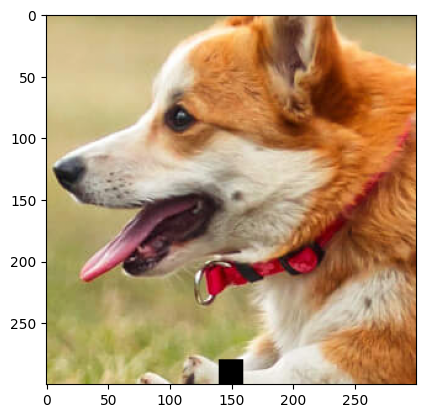

Iteration 0, Loss: 4101.563762831512


Iteration 200, Loss: 122.62152964600216
Iteration 400, Loss: 81.24630851059932
Iteration 600, Loss: 68.72575760913037
Iteration 800, Loss: 62.70689151322961


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


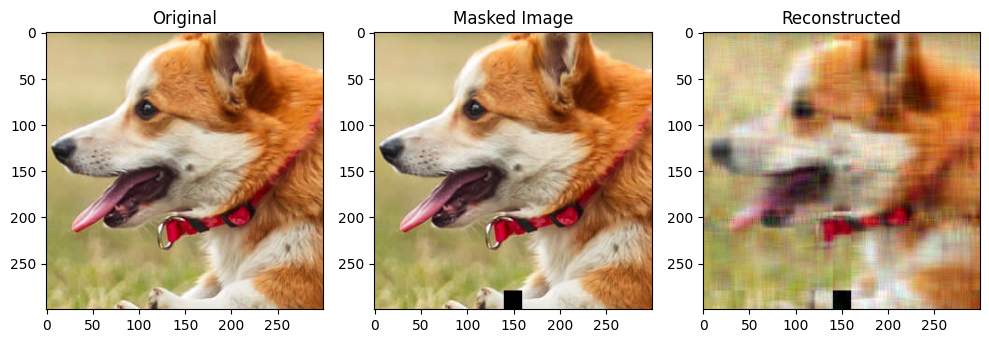

RMSE: 0.08693704050514131
PSNR: 21.215902961340017

Trying patch size: 40
Patch size 40 found a suitable single-colored area


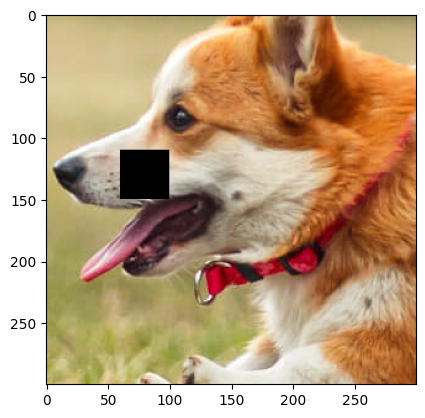

Iteration 0, Loss: 4090.116444748545
Iteration 200, Loss: 118.76473965545503
Iteration 400, Loss: 81.62540061413867
Iteration 600, Loss: 69.16886415770558
Iteration 800, Loss: 61.51254942041483


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


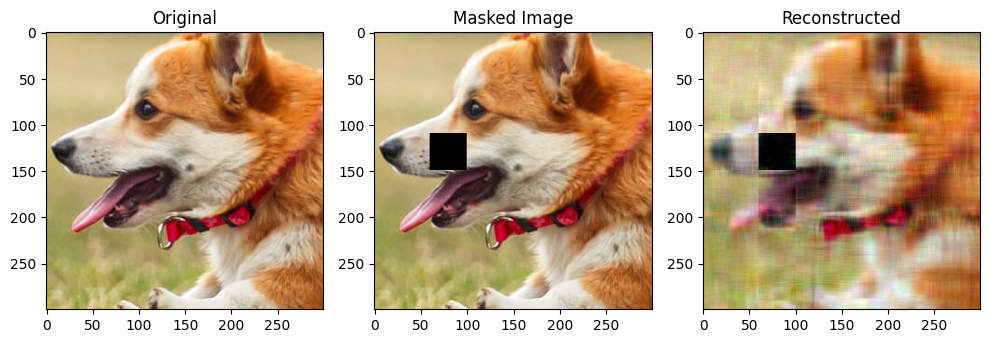

RMSE: 0.12107030857856076
PSNR: 18.33924701352739

Trying patch size: 60
Patch size 60 found a suitable multiple-colored area 


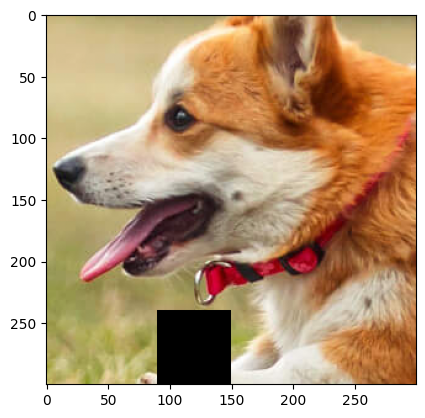

Iteration 0, Loss: 4041.3654254202984
Iteration 200, Loss: 112.67322860910986
Iteration 400, Loss: 76.54801025206362
Iteration 600, Loss: 68.12260109305387
Iteration 800, Loss: 61.67322000654818


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


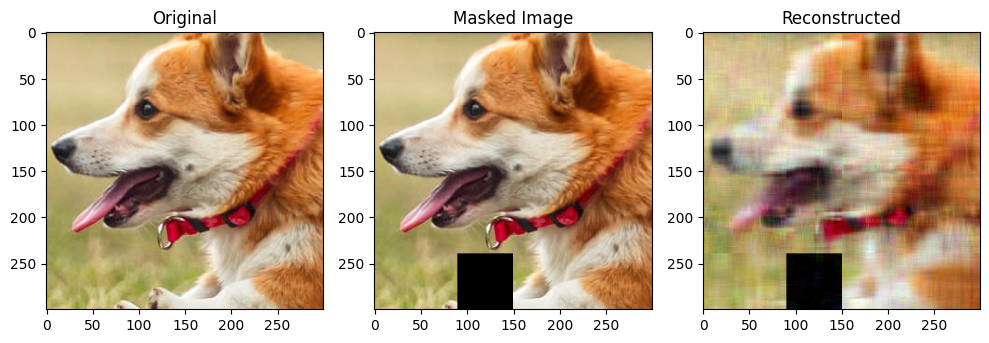

RMSE: 0.1420125822943992
PSNR: 16.95346350967033
Patch size 60 found a suitable area with at least 5 colors


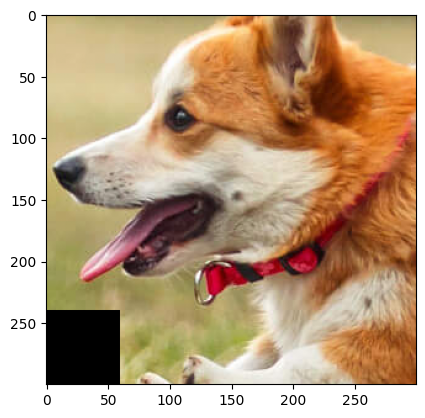

Iteration 0, Loss: 4041.6695724894425
Iteration 200, Loss: 115.20231418722642
Iteration 400, Loss: 81.50333000959722
Iteration 600, Loss: 69.71013098445968
Iteration 800, Loss: 61.794128587841456


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


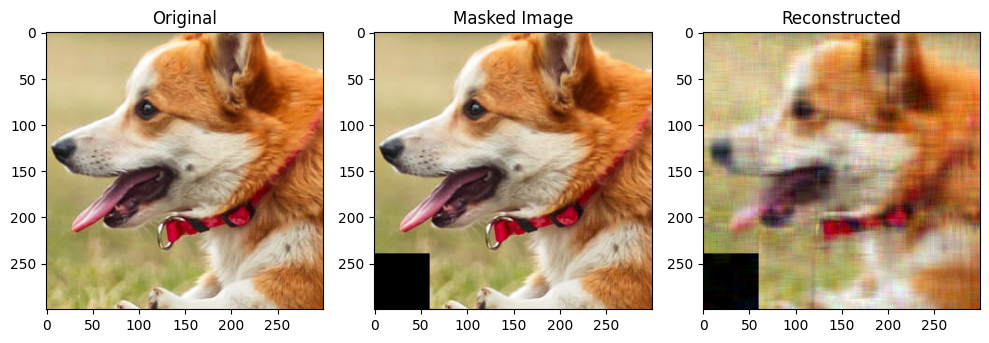

RMSE: 0.13591971120781862
PSNR: 17.334351137898526

Trying patch size: 80
Patch size 80 found a suitable multiple-colored area 


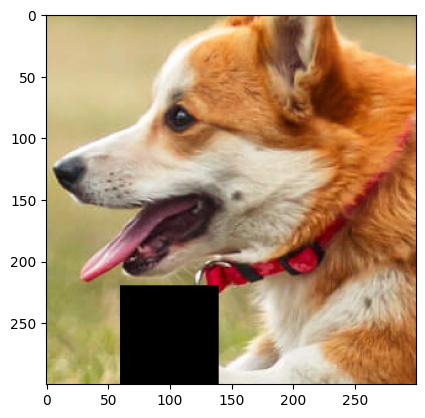

Iteration 0, Loss: 4113.010962194807
Iteration 200, Loss: 114.26806182720716
Iteration 400, Loss: 78.02131653625234
Iteration 600, Loss: 66.30223881207131
Iteration 800, Loss: 59.497087059915025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


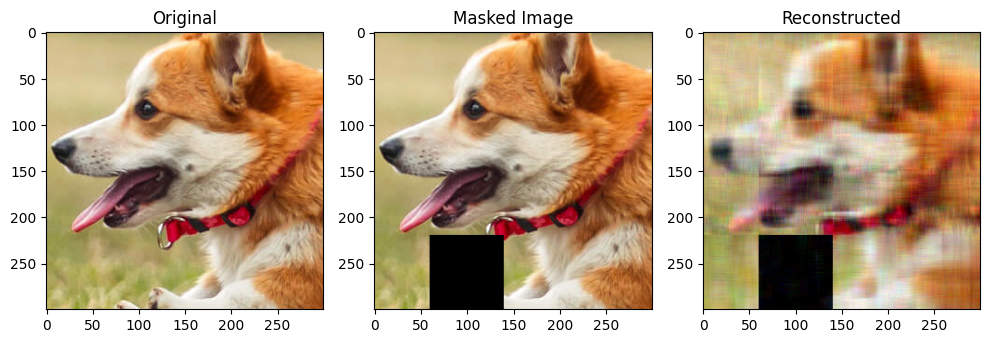

RMSE: 0.17309292209239363
PSNR: 15.234413808183982
Patch size 80 found a suitable area with at least 5 colors


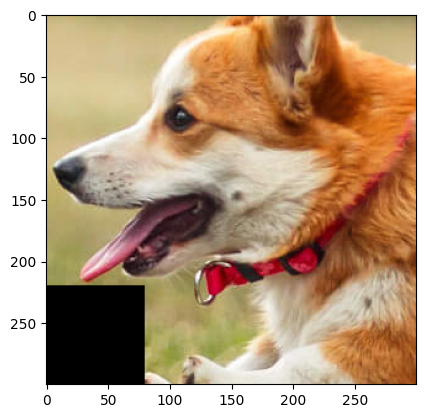

Iteration 0, Loss: 4051.585815552764
Iteration 200, Loss: 114.65038745164168
Iteration 400, Loss: 81.43826103942669
Iteration 600, Loss: 69.0039206922262
Iteration 800, Loss: 61.10081761805411


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


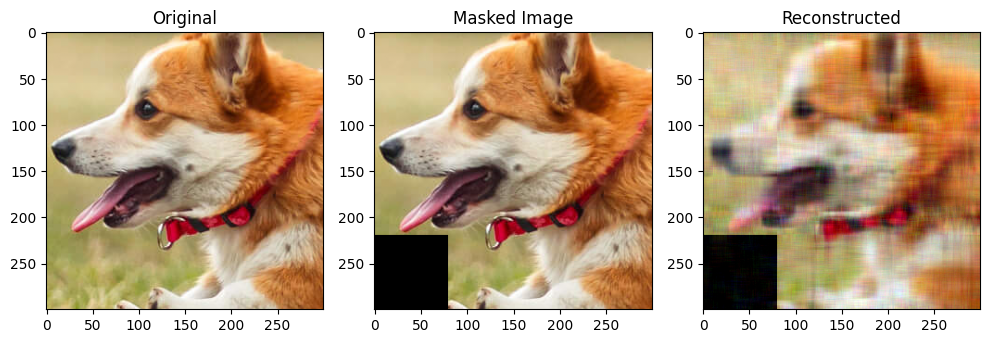

RMSE: 0.1698975968072018
PSNR: 15.396255283213872

Trying patch size: 100
Patch size 100 found a suitable multiple-colored area 


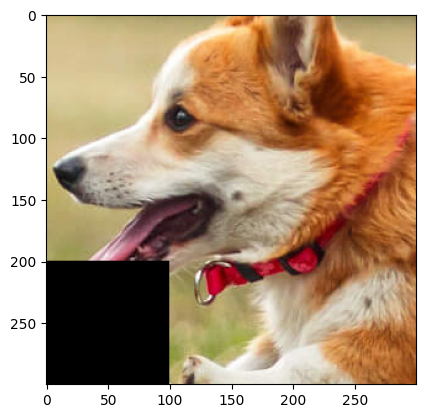

Iteration 0, Loss: 4074.3663706156035
Iteration 200, Loss: 114.55760819656723
Iteration 400, Loss: 75.50517933173906
Iteration 600, Loss: 63.958969884284556
Iteration 800, Loss: 57.5421279176057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


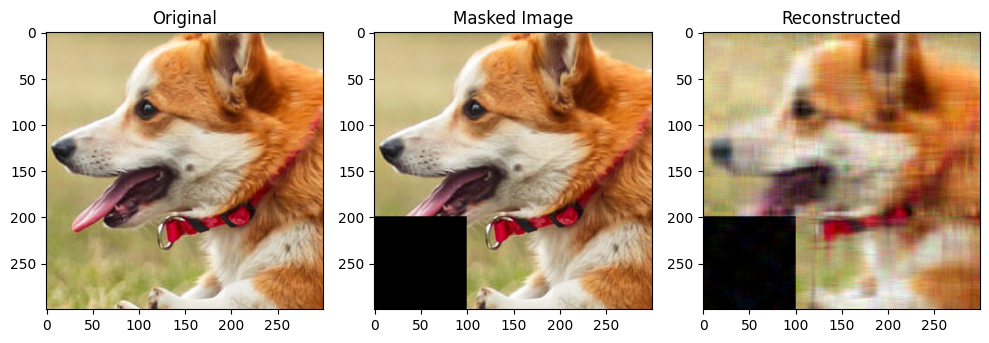

RMSE: 0.20348587768279264
PSNR: 13.829314525557482
Patch size 100 found a suitable area with at least 5 colors


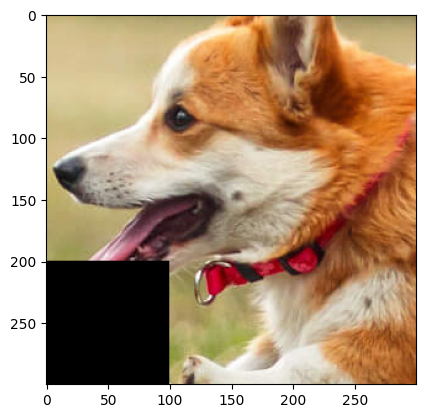

Iteration 0, Loss: 4034.4125249644862
Iteration 200, Loss: 111.59151663736651
Iteration 400, Loss: 76.07415903489257
Iteration 600, Loss: 65.91657848201453
Iteration 800, Loss: 59.05877970732584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


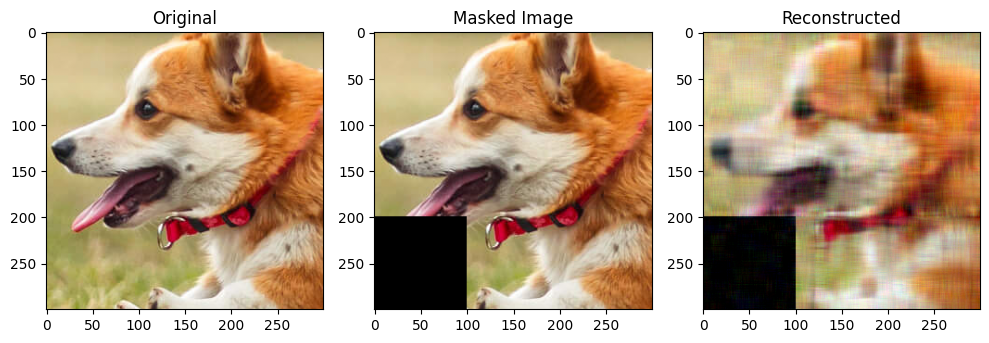

RMSE: 0.20378332180087336
PSNR: 13.81662725509476


In [504]:
patch_sizes = [20, 40, 60, 80, 100]
for block_size in patch_sizes:
    print(f"\nTrying patch size: {block_size}")

    # Flag to indicate if a patch has been plotted
    plotted_patch = False

    # Attempt to find single-colored patches first (and potentially plot)
    masked_image = create_masked_matrix_update(crop, block_size=block_size, color_criteria='single')
    if masked_image is not None:
        # Found a single-colored patch
        selected_region = None
        for y in range(masked_image.shape[1] - block_size, 0, -10):
            for x in range(0, masked_image.shape[2] - block_size, 10):
                patch = get_patch(masked_image, block_size, x, y)
                if is_mostly_single_color(patch):
                    selected_region = (y, x)
                    break

        if selected_region is not None:
            print(f"Patch size {block_size} found a suitable single-colored area")
            plt.imshow(rearrange(masked_image, 'c h w -> h w c').cpu().numpy())
            plt.show()
            plotted_patch = True  # Mark a patch as plotted
            perform_gradient_descent_reconstruction(crop, masked_image, num_iterations=1000, rank=20, learning_rate=0.01)

    # Check for other criteria only if no patch has been plotted yet
    if not plotted_patch:
        masked_image = create_masked_matrix_update(crop, block_size=block_size, color_criteria='multiple')
        if masked_image is not None:
            selected_region = None
            for y in range(masked_image.shape[1] - block_size, 0, -10):
                for x in range(0, masked_image.shape[2] - block_size, 10):
                    patch = get_patch(masked_image, block_size, x, y)
                    if has_multiple_channels(patch):
                        selected_region = (y, x)
                        break
            if selected_region is not None:
                x_min, y_min = selected_region
                print(f"Patch size {block_size} found a suitable multiple-colored area ")
                plt.imshow(rearrange(masked_image, 'c h w -> h w c').cpu().numpy())
                plt.show()
                plotted_patch = True    
                perform_gradient_descent_reconstruction(crop, masked_image, num_iterations=1000, rank=20, learning_rate=0.01)    

        masked_image = create_masked_matrix_update(crop, block_size=block_size, color_criteria='5_colors')
        if masked_image is not None:
            selected_region = None
            for y in range(masked_image.shape[1] - block_size, 0, -10):
                for x in range(0, masked_image.shape[2] - block_size, 10):
                    patch = get_patch(masked_image, block_size, x, y)
                    if has_at_least_n_colors(patch):
                        selected_region = (y, x)
                        break
            if selected_region is not None:
                x_min, y_min = selected_region
                print(f"Patch size {block_size} found a suitable area with at least 5 colors")
                plt.imshow(rearrange(masked_image, 'c h w -> h w c').cpu().numpy())
                plt.show()
                plotted_patch = True
                perform_gradient_descent_reconstruction(crop, masked_image, num_iterations=1000, rank=20, learning_rate=0.01)


In [511]:
import matplotlib.patches as patches

def get_patch(image,patch_size,x_min,y_min):
    return image[:,y_min:y_min+patch_size,x_min:x_min+patch_size]

def plot_image_with_patch(image, patch_size, x, y, ax, highlight_color="red",mask_color="gray"):
    # Convert image to numpy array and adjust for plotting
    image_np =  rearrange(crop, 'c h w -> h w c').cpu().numpy()

    # Plot the original image on the provided axis
    ax.imshow(image_np)
    # Create a rectangle patch for highlighting
    rect = patches.Rectangle(
        (x, y),
        patch_size,
        patch_size,
        linewidth=2,
        edgecolor=highlight_color,
        facecolor=mask_color
    )

    # Add the patch to the plot
    ax.add_patch(rect)

    ax.set_xlim(0, image_np.shape[1])  # set x-axis limit
    ax.set_ylim(image_np.shape[0], 0)  # set y-axis limit, reversing the direction
    ax.set_title("Image with Patches")

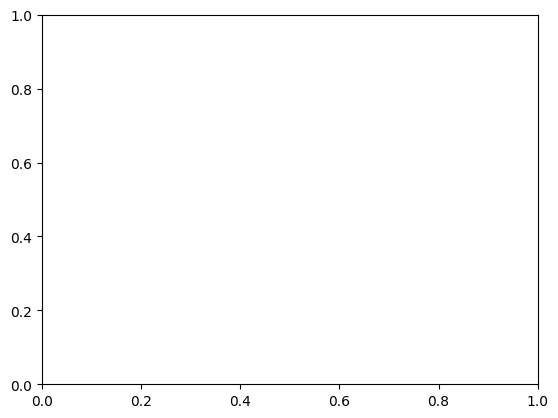

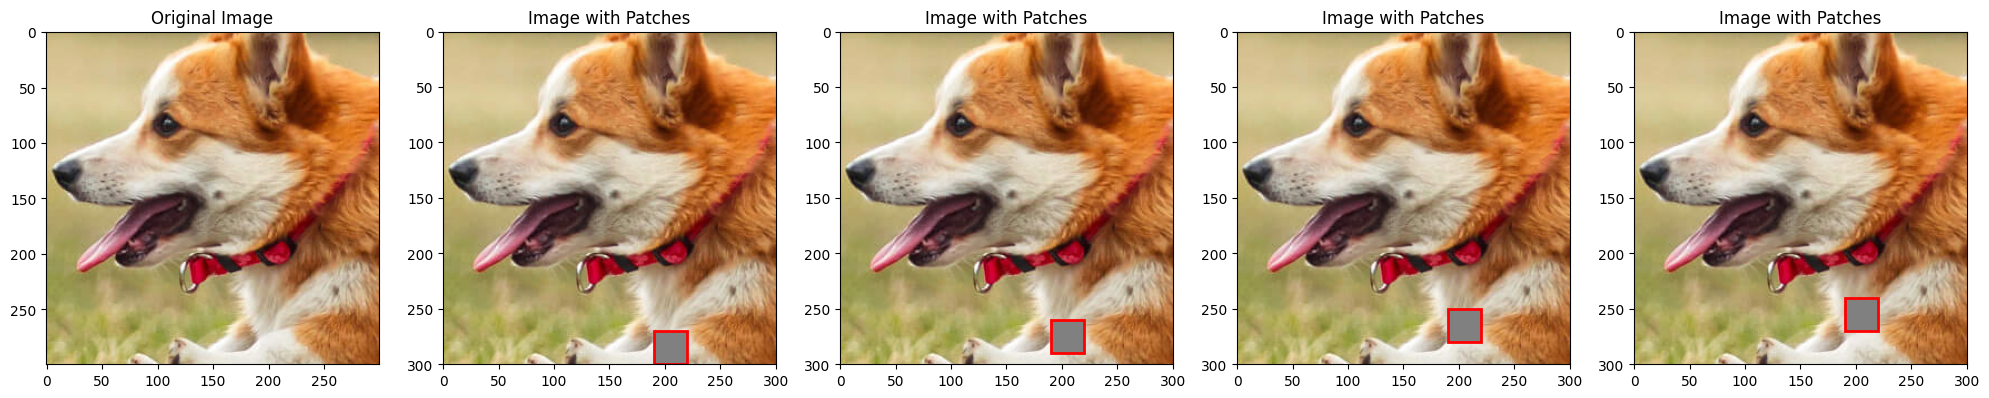

In [512]:
# Your image and patch parameters
image_shape = (3, 300, 300)
patch_size = 30
min_x = 0
max_x = image.shape[2] - patch_size
min_y = image.shape[1] - patch_size
max_y = 0
plot_counter = 1
# Create a single figure and axis for the big image
fig, ax = plt.subplots()
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# # Plot the big image once
image_np =  rearrange(crop, 'c h w -> h w c').cpu().numpy()
axs[0].imshow(image_np)
axs[0].set_title("Original Image")
# Iterate over the patches and plot them on the same axis
for y in range(min_y, max_y - 1, -10): 
    for x in range(min_x, max_x, 10):
        if plot_counter >= len(axs):
            break        

        patch = get_patch(image, patch_size, x, y)
        if is_mostly_single_color(patch):
            plot_image_with_patch(image, patch_size, x, y, axs[plot_counter])
            plot_counter+=1
            break

# Show the plot
plt.tight_layout()            
plt.show()


In [386]:
def has_multiple_channels(patch,threshold=0.1,min_channel=2):
    std_devs_per_channel=torch.std(patch,dim=(1,2))
    return (std_devs_per_channel > threshold).sum()>=min_channel


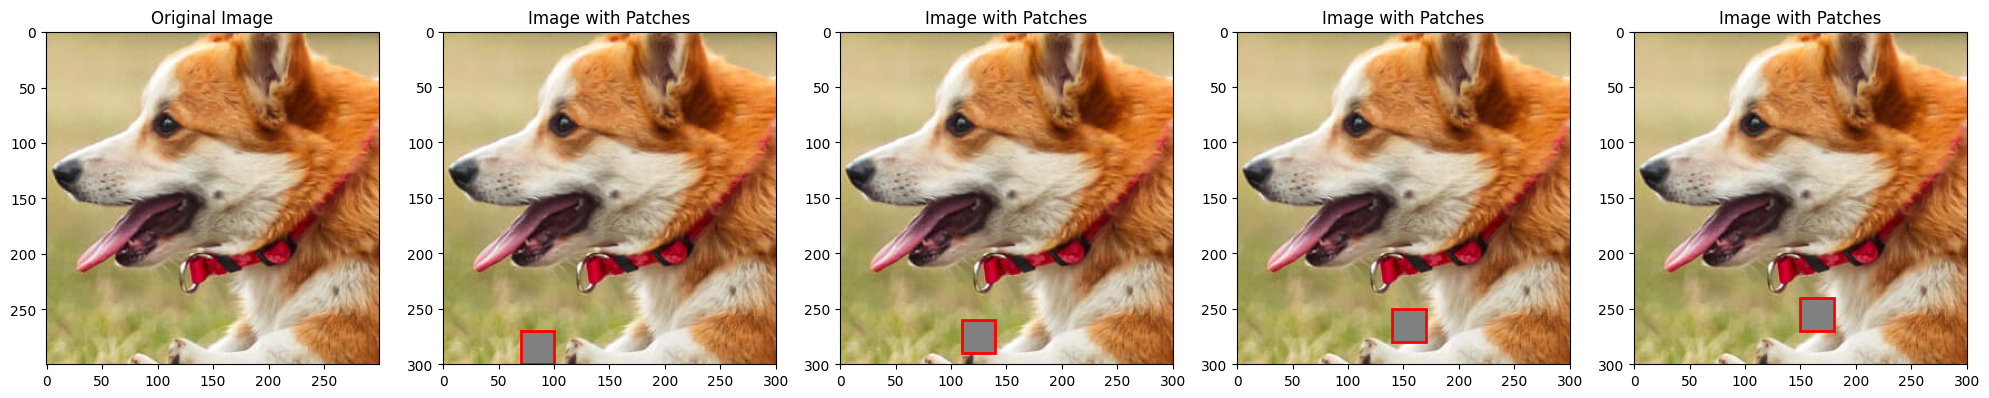

In [387]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
plot_counter = 0

axs[0].imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
axs[0].set_title("Original Image")
plot_counter = 1
# Iterate over the patches and plot them on the same axis
for y in range(min_y, max_y - 1, -10): 
    for x in range(min_x, max_x, 10):
        if plot_counter >= len(axs):
            break        

        patch = get_patch(image, patch_size, x, y)
        if has_multiple_channels(patch, threshold=0.1, min_channel=2):
            plot_image_with_patch(image, patch_size, x, y, axs[plot_counter])
            plot_counter += 1
            break

# Show the plot
plt.tight_layout()            
plt.show()


In [388]:
def has_at_least_n_colors(patch, min_colors=5):
    unique_colors_per_channel = [torch.unique(patch[channel, :, :]).shape[0] for channel in range(patch.shape[0])]
    # print(unique_colors_per_channel)
    # print(unique_colors_per_channel)
    return all(count >= min_colors for count in unique_colors_per_channel)


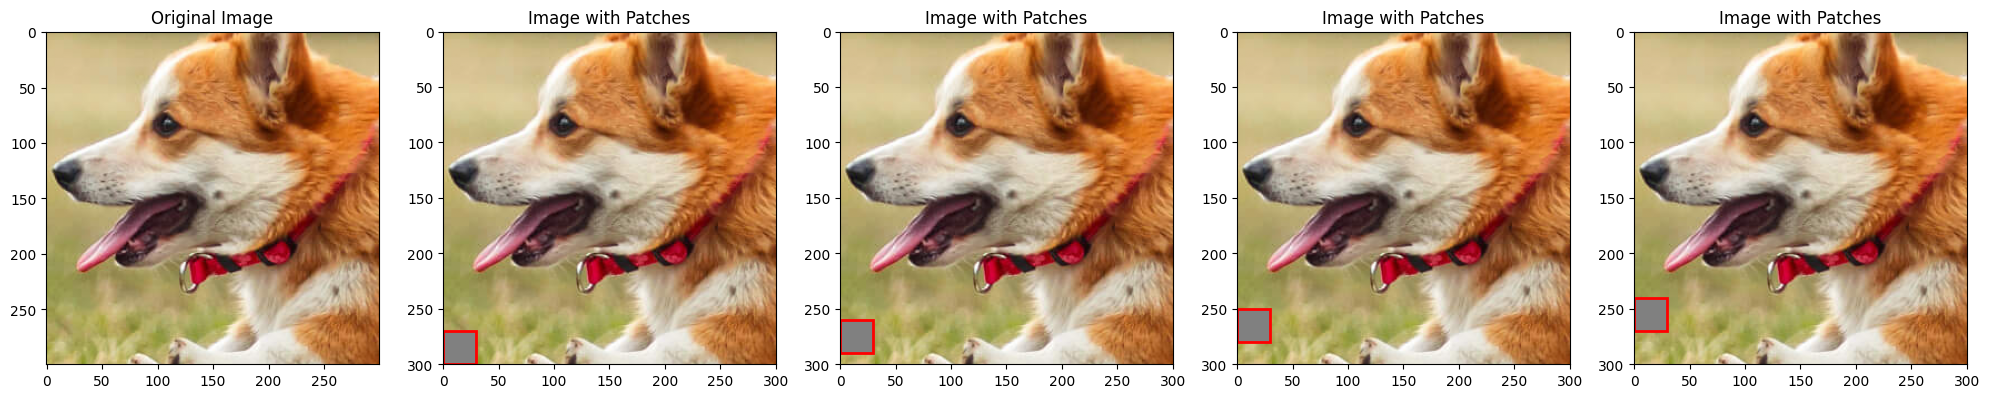

In [389]:
# fig, ax = plt.subplots()
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
plot_counter = 0

# # Plot the big image once
image_np =  rearrange(crop, 'c h w -> h w c').cpu().numpy()
axs[0].imshow(image_np)
axs[0].set_title("Original Image")
plot_counter = 1
# Iterate over the patches and plot them on the same axis
for y in range(min_y, max_y - 1, -10): 
    for x in range(min_x, max_x, 10):
        if plot_counter >= len(axs):
            break        

        patch = get_patch(image, patch_size, x, y)
        if has_at_least_n_colors(patch, min_colors=5):
            plot_image_with_patch(image, patch_size, x, y, axs[plot_counter])
            plot_counter+=1
            break

# Show the plot
plt.tight_layout()            
plt.show()